<a href="https://colab.research.google.com/github/manavgarg/MOOC/blob/master/Copy_of_rl_tabular_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Tabular Q-Learning with Policy Algorithms

In the previous Colab, you used Q-learning to build a table of rewards. In this Colab, you'll learn to exploit the table of Q-values. **Tabular Q-Learning** refers to implementing Q-learning by using a table of Q-values.

## Copyright 2019 Google LLC.

In [ ]:
#@title
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

Run the following cell to setup Google Analytics for the Colab. Data from  Google Analytics helps improve the Colab.

In [ ]:
#@title Set up Google Analytics for Colab
%reset -f
import uuid
client_id = uuid.uuid4()

import requests

# Bundle up reporting into a function.
def report_execution():
  requests.post('https://www.google-analytics.com/collect', 
                data=('v=1'
                      '&tid=UA-48865479-3'
                      '&cid={}'
                      '&t=event'
                      '&ec=cell'            # <-- event type
                      '&ea=execute'         # <-- event action
                      '&el=rl-tabular-q-learning'   # <-- event label
                      '&ev=1'               # <-- event value
                      '&an=bundled'.format(client_id)))

from IPython import get_ipython
get_ipython().events.register('post_execute', report_execution)

Run the following cell to import libraries and create the environment. The environment is called `FrozenLake-v0`. You will explore the environment in the next section.

In [1]:
import numpy as np
import gym
import time
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output # to clear output on every episode run

np.set_printoptions(precision=5, suppress=True)

env = gym.make('FrozenLake-v0')
state = env.reset()

## Understand the Environment

The [`FrozenLake-v0`](https://gym.openai.com/envs/FrozenLake-v0) environment is more complex than `NChain-v0`. You must cross a frozen lake to retrieve a frisbee. The lake is a 4x4 grid:
    
          SFFF
          FHFH
          FFFH
          HFFG

      S : starting point, safe
      F : frozen surface, safe
      H : hole, fall to your doom
      G : goal, where the frisbee is located

You start at the top-left cell. The frisbee is in the bottom-right cell. You receive a reward of 1 upon reaching the frisbee, and 0 for all other transitions. The episode ends on reaching the frisbee or falling into a hole. Warning: Because the ice is slippery, the result of taking an action (up, down, left, right) is probabilistic.

First, record the number of possible states and actions:

In [2]:
num_states = env.observation_space.n
print("Number of states: " + str(num_states))
num_actions = env.action_space.n
print("Number of actions: " + str(num_actions))

Number of states: 16
Number of actions: 4


Run the following cell a few times to observe an episode and understand the environment. The output shows an agent stepping through a full episode using a random policy. The action taken is in parentheses. Notice how the agent's state transitions often do not correspond to the action taken. The environment is very probabilistic.

In [10]:
done = False
state = env.reset()
env.render()

while not done:
  clear_output(True)
  state_next, reward, done, _ = env.step(env.action_space.sample())
  env.render()
  time.sleep(1.0)
  state = state_next

  (Up)
SFFF
FHFH
FFFH
HFFG


## Random & Greedy Policies



Build the Q-values table for the environment by using a random policy to explore the enviroment. First, define the random policy:

In [11]:
def policy_random():
  return env.action_space.sample()

Define a function to update the Q-table using the Bellman equation: 

$$Q(s,a) \gets Q(s,a) + \alpha
  \left[r(s,a)
      + \gamma \displaystyle\max_{\substack{a_1}} Q(s_1,a_1)
    - Q(s,a) \right]
$$

Complete the function's code as indicated:

In [13]:
def bellman_update(q_table, learning_rate, discount_factor, reward, state, state_next, action):
  q_table[state,action] = q_table[state, action] + learning_rate*((reward + discount_factor*(np.max(q_table[state_next, :]))) - q_table[state, action])# TODO: bellman update
  return q_table

In [ ]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
def bellman_update(q_table, learning_rate, discount_factor, reward, state, state_next, action):
  q_table[state,action] = q_table[state, action] + \
                            learning_rate*(reward + \
                                   discount_factor*np.max(q_table[state_next,:]) - \
                                   q_table[state, action]
                                 )
  return q_table

Define a function to run an episode using the random policy and the Bellman update. Complete the function as indicated:

In [ ]:
def run_random_episode(env, q_table, learning_rate, discount_factor):
  state = env.reset()
  done = False
  
  while(not done):
    action =  policy_random() # TODO
    state_next, reward, done, _ =  env.step(action)# TODO
    q_table = bellman_update(q_table, learning_rate, discount_factor, reward, state, state_next, action) # TODO
    state =   state_next# TODO
  
  return(q_table)

In [14]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
def run_random_episode(env, q_table, learning_rate, discount_factor):
  state = env.reset()
  done = False
  
  while(not done):
    action = policy_random()
    state_next, reward, done, _ = env.step(action)
    q_table = bellman_update(q_table, learning_rate, discount_factor, reward, state, state_next, action)
    state = state_next
  
  return(q_table)

Create the Q-table by running the random policy for a few thousand episodes. Do not try to read the resulting Q-table closely because the table is complex. Instead, note the following characteristics of the Q-table:

* Q-values remain 0 for the terminal states (the holes and the goal state) because no transitions occur from terminal states.
* Q-value for the final state-action pair that precedes the goal, (s=14, a=2), is set to 100 by the code. The code normalizes all other Q-values.
* The higher the Q-value of a state-action pair, the closer that state-action pair is to the goal.

In [20]:
discount_factor = 0.9 # typical value
learning_rate = 0.5 # typical value for FrozenLake is 0.1 to 0.8
episodes = 2000 # typically varies from 5000 to 15000

q_table = np.zeros([num_states, num_actions])

# Normalize Q-values for readability
def normalize_q_values(q_table):
  q_table_max = np.max(q_table)
  if q_table_max > 0.0:  # if agent never succeeds, then max(q_table) = 0
    q_table = (q_table/q_table_max)*100.0
  return q_table

for episode in range(episodes):
  q_table = run_random_episode(env, q_table, learning_rate, discount_factor)
print(normalize_q_values(q_table))

[[ 30.80251  32.73195  36.31511  29.99717]
 [ 28.37993  31.09035  20.46147  32.1351 ]
 [ 37.07269  47.03324  34.50106  31.55992]
 [  3.03552  15.47848   8.00841  29.38526]
 [ 39.79727  44.73761  22.40886  15.54672]
 [  0.        0.        0.        0.     ]
 [ 61.3474   12.2081   67.54477  22.81914]
 [  0.        0.        0.        0.     ]
 [ 12.36557  15.04823  13.56628  65.89368]
 [  4.54231  47.059    81.08932  32.23258]
 [ 76.23481  71.30137  87.44957  42.33622]
 [  0.        0.        0.        0.     ]
 [  0.        0.        0.        0.     ]
 [ 62.2786   92.90598  82.1514   37.85936]
 [ 86.61615  92.82425 100.       88.25974]
 [  0.        0.        0.        0.     ]]


Using these Q-values, you can exploit the environment by following the path of maximum Q. A policy that exploits the environment by maximizing Q is called a **greedy policy**.

Define a policy function that uses Q-values to greedily choose an action:

In [21]:
def policy_greedy(q_table, state):
  return np.argmax(q_table[state,:])

Run the following code to follow a greedy policy and find the successful percentage of episodes. The greedy policy has a low success percent. Therefore, the Q-values must be inaccurate.

In [22]:
total_reward = 0.0

num = 10000
for episode in range(num):
  state = env.reset()
  done = False
  while(not done):
    action = policy_greedy(q_table, state)
    state, reward, done,_ = env.step(action)
  total_reward += reward

print("Percentage of successful episodes: " + \
      str(total_reward / num * 100) + "%.")

Percentage of successful episodes: 7.5200000000000005%.


## Balancing Exploitation with Exploration

Why are the Q-values inaccurate after thousands of episodes of exploration? At the beginning, all Q-values are 0. As the agent runs successive episodes with a random policy, the agent finds rewarding paths. However, the random policy doesn't let the agent change behavior to exploit the most rewarding paths. Therefore, the agent does not explore the environment enough to find the paths that lead to maximum return.

To improve upon a random policy, you can use an **epsilon greedy** (e-greedy) policy instead. This policy takes a random action with epsilon probability and a greedy action otherwise. The value of epsilon decays over successive episodes, such that the policy gradually switches from random exploration to choosing the paths that maximize reward.

Control the rate of epsilon's decay by multiplying epsilon by a decay factor on every episode. Set the decay factor between 0 and 1; typically very close to 1, such as 0.99. Therefore, the higher the decay factor, the slower epsilon decays. Understand this relation by running the following cell to visualize epsilon's decay. Try changing `episodes` and `eps_decay`, and check the result.

Text(0, 0.5, 'Epsilon')

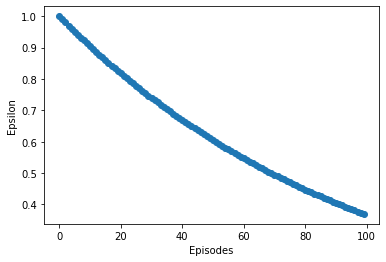

In [23]:
eps_decay = 0.99
episodes = 100

epsilon = 1.0
eps_values = np.zeros(episodes)

for episode in range(episodes):
  eps_values[episode] = epsilon
  epsilon *= eps_decay

# Plot epsilon values
plt.scatter(range(episodes),eps_values)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')

## Implement Epsilon Greedy Policy

In the following cell, implement the epsilon-greedy policy by selecting a random action or greedy action where indicated by `TODO`:

In [25]:
def policy_eps_greedy(q_table, state, epsilon):
  if (np.random.random() < epsilon): #TODO
    action = policy_random() # TODO
  else:
    action = policy_greedy(q_table, state) # TODO
  return action

In [31]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
def policy_eps_greedy(q_table, state, epsilon):
  if(np.random.random() < epsilon):
    action = policy_random()
  else:
    action = policy_greedy(q_table, state)
  return action

Using the function `policy_eps_greedy`, define a function to run an episode and update the Q-table:

In [26]:
def run_epsilon_greedy_episode(env, q_table, epsilon, learning_rate, discount_factor):
  state = env.reset()
  done = False
  episode_return = 0
  
  while(not done):
    action = policy_eps_greedy(q_table, state, epsilon)
    state_next, reward, done, _ = env.step(action)
    episode_return += reward
    q_table = bellman_update(q_table, learning_rate, discount_factor, reward, state, state_next, action)
    state = state_next
  
  return(reward, q_table)

## Train Agent to Solve Frozen Lake

To train the agent, define a function that accepts the environment and agent hyperparameters, and runs episodes to update the Q-table.

In [30]:
def train_agent(env, epsiodes, learning_rate, discount_factor, eps_decay):
  reward_history = np.array([])
  q_table = np.zeros([num_states, num_actions])
  epsilon = 1.0
  
  for episode in range(episodes):
    reward, q_table = run_epsilon_greedy_episode(env, q_table, epsilon, learning_rate, discount_factor)
    reward_history = np.append(reward_history, reward)
    if(epsilon > EPS_MIN):
      epsilon *= eps_decay
  
  return(reward_history, q_table)

Train the agent to solve FrozenLake. The code displays the Q-table along with plots that show how success increases with episodes. Adjust hyperparameters to boost success.  For the solution, expand the following section.

### How to Adjust Hyperparameters

Adjusting hyperparameters in ML models is part art, part science. For general guidelines, see the [Testing & Debugging in Machine Learning](https://developers.google.com/machine-learning/testing-debugging/) course. In addition, consider the following guidelines for simple RL problems:

* Results of RL training runs are variable because the environment is probabilistic, and because Q-values are arbitarily initialized. Do not rely on a single training run to evaluate a set of hyperparameter values. Try a few runs.
* If your agent is not successful, then perhaps epsilon decays before random exploration succeeds. Let your agent explore for longer by increasing `eps_decay`. Typically, `eps_decay` should be very close to 1.
* If your agent has a few successes, but does not exploit those successes, then try the following steps:
  * Adjust the learning rate. For general guidance on adjusting learning rate, see the section "Adjust Hyperparameter Values" on the page [Model Debugging](https://developers.google.com/machine-learning/testing-debugging/common/model-errors) from the Testing & Debugging course.
  * Train for longer by increasing the number of episodes.
  * Try increasing `discount_factor` to ensure that the reward backpropagates sufficiently to the Q-values for the initial states.

[[  2.12343   2.19528   2.10397   1.81066]
 [  1.27794   1.66058   1.843     2.52047]
 [  4.77444   3.70919   4.07296   2.38151]
 [  1.58091   1.6988    1.07743   2.3571 ]
 [  4.28909   3.08693   3.04233   1.48439]
 [  0.        0.        0.        0.     ]
 [  7.36953   7.11878   7.92213   0.8612 ]
 [  0.        0.        0.        0.     ]
 [  2.4824    7.54801   6.50807  10.19409]
 [ 12.93482  20.53709  15.58677   8.48287]
 [ 24.85401  29.03774  24.16589   5.22174]
 [  0.        0.        0.        0.     ]
 [  0.        0.        0.        0.     ]
 [ 11.9301   35.18809  32.92468  22.04055]
 [ 33.74629  83.56293 100.       63.62161]
 [  0.        0.        0.        0.     ]]

Success rate: 24.0%.


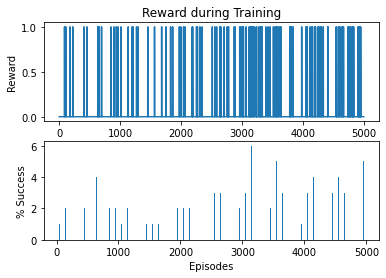

In [32]:
# Hyperparameters
eps_decay = 0.9999 #@param
episodes = 5000    #@param
discount_factor = 0.8        #@param
learning_rate = 0.03       #@param

# minimum value of epsilon is typically set to 0.01
EPS_MIN = 0.01

# Run agent
reward_history, q_table = train_agent(env, episodes, learning_rate, discount_factor, eps_decay)

# Normalize Q-values for readability
print(normalize_q_values(q_table))

# Check success %
def check_success(env, q_table):
  success = 0
  for episode in range(100):
    state = env.reset()
    done = False
    reward = 0
    while not done:
      state, reward, done, _ = env.step(policy_greedy(q_table, state))
    success += reward
  print("\nSuccess rate: " + str(success) + "%.")

check_success(env, q_table)
    
# Plot reward and success % over episodes.
def visualize_training(reward_history):
  plt.subplot(2,1,1)
  plt.plot(range(len(reward_history)), reward_history)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')
  plt.title('Reward during Training')
  num_bins = episodes/100
  plt.subplot(2,1,2)
  plt.hist(np.nonzero(reward_history)[0], bins=int(num_bins), range=(0,episodes), rwidth=0.1)
  plt.xlabel('Episodes')
  plt.ylabel('% Success')

visualize_training(reward_history)

### Solution (expand to view)

Run the following cell to successfully train the agent. Observe the following:

* The epsilon-greedy policy calculates different Q-values from the purely random policy.
* The agent's success rate gradually increases as the agent learns the environment.

[[0.23916 0.13999 0.08002 0.19602]
 [0.02097 0.0217  0.01655 0.19204]
 [0.11426 0.05559 0.0275  0.05626]
 [0.01257 0.01461 0.01349 0.0431 ]
 [0.26414 0.06836 0.02191 0.03007]
 [0.      0.      0.      0.     ]
 [0.00566 0.05453 0.08347 0.00456]
 [0.      0.      0.      0.     ]
 [0.01705 0.02725 0.08218 0.36218]
 [0.09641 0.44809 0.08778 0.0861 ]
 [0.24941 0.00567 0.03122 0.02101]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.01657 0.27134 0.56323 0.14051]
 [0.18575 0.8849  0.21016 0.52388]
 [0.      0.      0.      0.     ]]

Success rate: 72.0%.


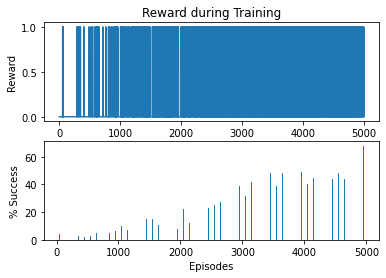

In [34]:
# Set parameters
eps_decay = 0.999
episodes = 5000
discount_factor = 0.95
learning_rate = 0.5

# minimum value of epsilon is typically set to 0.01
EPS_MIN = 0.01

# Run agent, print q-values, and plot reward history
reward_history, q_table = train_agent(env, episodes, learning_rate, discount_factor, eps_decay)
print(q_table)
visualize_training(reward_history)
check_success(env, q_table)

## Conclusion and Next Steps

The e-greedy policy successfully balances exploration and exploitation. Combining tabular Q-learning with an epsilon-greedy policy is a powerful approach to solving simple environments.

Move onto the next Colab: [Deep Q-Learning](https://colab.research.google.com/drive/1XnFxIE882ptpO83mcAz7Zg8PxijJOsUs#forceEdit=true&sandboxMode=true?utm_source=ss-reinforcement-learning&utm_campaign=colab-external&utm_medium=referral&utm_content=rl-deep-q-learning).

For reference, the sequence of course Colabs is as follows:

1. [Problem Framing in Reinforcement Learning](https://colab.research.google.com/drive/1sUYro4ZyiHuuKfy6KXFSdWjNlb98ZROd#forceEdit=true&sandboxMode=true?utm_source=ss-reinforcement-learning&utm_campaign=colab-external&utm_medium=referral&utm_content=rl-problem-framing)
1. [Q-learning Framework](https://colab.research.google.com/drive/1ZPsEEu30SH1BUqUSxNsz0xeXL2Aalqfa#forceEdit=true&sandboxMode=true?utm_source=ss-reinforcement-learning&utm_campaign=colab-external&utm_medium=referral&utm_content=rl-q-learning)
1. [Tabular Q-Learning](https://colab.research.google.com/drive/1sX2kO_RA1DckhCwX25OqjUVBATmOLgs2#forceEdit=true&sandboxMode=true?utm_source=ss-reinforcement-learning&utm_campaign=colab-external&utm_medium=referral&utm_content=rl-tabular-q-learning)
1. [Deep Q-Learning](https://colab.research.google.com/drive/1XnFxIE882ptpO83mcAz7Zg8PxijJOsUs#forceEdit=true&sandboxMode=true?utm_source=ss-reinforcement-learning&utm_campaign=colab-external&utm_medium=referral&utm_content=rl-deep-q-learning)
1. [Experience Replay and Target Networks](https://colab.research.google.com/drive/1DEv8FSjMvsgCDPlOGQrUFoJeAf67cFSo#forceEdit=true&sandboxMode=true?utm_source=ss-reinforcement-learning&utm_campaign=colab-external&utm_medium=referral&utm_content=rl-experience-replay-and-target-networks)